<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploring-github-APIs-possibilities" data-toc-modified-id="Exploring-github-APIs-possibilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploring github APIs possibilities</a></span></li></ul></div>

This notebook contains code that was used to explore
the github API in view of making `hubcap`.

I give no assurances as to if anything still works here.

In [75]:
from guide import print_attrs_info

# General Object

In [52]:
from functools import cached_property
from operator import attrgetter

from dol import KvReader
from dol.util import format_invocation
from hubcap import RepoReader, Issues, IssueComments
from hubcap.base import Workflows
from hubcap.constants import repo_collection_names

print(f"{len(repo_collection_names)=}")


len(repo_collection_names)=46


In [4]:
w = Workflows('thorwhalen/hubcap')
print(f"{list(w)=}")
w[15622701].url

list(w)=[15622701, 19162183]


'https://api.github.com/repos/thorwhalen/hubcap/actions/workflows/15622701'

In [2]:
from hubcap import RepoReader

r = RepoReader('thorwhalen/hubcap')
all(k in r for k in {'discussions', 'issues', 'workflows'})

Request GET /repos/thorwhalen/hubcap failed with 403: rate limit exceeded
Setting next backoff to 2000.155305s


In [8]:
issues = rr['issues']
list(issues)

[3]

In [10]:
t = issues[3]
t.comments

1

## Tests

In [57]:
from hubcap import RepoReader
rr = RepoReader('thorwhalen/test_repo')
repo_level_keys = list(rr)
print(f"{len(repo_level_keys)=}")
print(f"{repo_level_keys=}")

len(repo_level_keys)=47
repo_level_keys=['artifacts', 'assignees', 'autolinks', 'branches', 'codescan_alerts', 'collaborators', 'comments', 'commits', 'contributors', 'deployments', 'discussions', 'downloads', 'environments', 'events', 'forks', 'git_refs', 'hooks', 'issues', 'issues_comments', 'issues_events', 'labels', 'languages', 'milestones', 'network_events', 'notifications', 'pending_invitations', 'projects', 'pulls', 'pulls_comments', 'pulls_review_comments', 'releases', 'repository_advisories', 'secrets', 'self_hosted_runners', 'stargazers', 'stargazers_with_dates', 'stats_contributors', 'subscribers', 'tags', 'teams', 'top_paths', 'top_referrers', 'topics', 'variables', 'watchers', 'workflow_runs', 'workflows']


In [61]:
from hubcap.constants import repo_collection_names
(set(repo_collection_names) | {'discussions'}) == set(repo_level_keys)

True

{'discussions'}

# Get openAPI specs of github API

So we have this ledger:

```python
dflt_repo_kwargs = dict(
    issues=dict(objs_to_items='number', get_objs_kwargs=(('state', 'open'),)),
    workflows=dict(objs_to_items='id'),
    branches=dict(objs_to_items='name'),
)
```

that is used by `repo_objects_instance` to give `RepoObjects` some defaults specific to the repository collection name (issues, workflows, etc.). Namely, the `objs_to_items` that determines what will be used as a key. 

I specified the three above by "manually" looking into the docs and choosing the one I wanted. 
That's not scalable!
What can I do to automate this process so I can maintain it more easily.

This is what this section is about.

My plan:
* Make a list of `repo_collection_names`, which are the (object) names we need to find 
keys for
* Get a hold of the OpenAPI specs for the github API
* Extract the specs for repository endpoints (that correspond to collections). 
We'll call `repo_endpoints` the dict whose keys are endpoints and values are it's 
specification -- namely, what we're interested in here; the schema of the output of 
the endpoint's http service call; even more specifically, the names of the "attributes"
of the objects it returns, which is where we'll hunt for our unique key.
* Extract from there the names (and possibly descriptions) of the output schemas
* Make a table with this information
* Study that a bit to see if there's an obvious pattern
* Choose a key name for each of the collection (possibly asking AI to help)


## repo_collection_names

In [161]:
# Get the target collection names from the github.Repository class (see code for details)
from hubcap.constants import repo_collection_names

print(f"{len(repo_collection_names)=}")
print(f"repo_collection_names:{repo_collection_names.__doc__}")

len(repo_collection_names)=46
repo_collection_names:
    List of the names of the objects that can be retrieved from a repository
    (e.g. commits, contributors, issues, pull_requests, releases, tags, etc.)
    These names are extracted by taking all the method names of the
    `github.Repository` class that start with `get_` and end with `s`,
    and removing the `get_` prefix.
    


## OpenAPI specs - Routes of github API

In [1]:
# Get openAPI sepcification of the github API
from graze import graze
import yaml
b = graze('https://raw.githubusercontent.com/github/rest-api-description/main/descriptions/api.github.com/api.github.com.yaml')
oas = yaml.load(b, Loader=yaml.FullLoader)
list(oas)

['openapi',
 'info',
 'tags',
 'servers',
 'externalDocs',
 'paths',
 'x-webhooks',
 'components']

In [2]:
# Extract the routes
from ju import Routes

routes = Routes(oas)
len(routes)

911

## repo_endpoints

In [3]:
# Keep only the get-method routes for repositories operations
repo_specs = list(filter(lambda x: x[0] == 'get' and x[1].startswith('/repo'), routes))
print(f"{len(repo_specs)=}")

len(repo_specs)=222


In [162]:
# of these string keys (repo_collection_names), find endpoints that end with that string
repo_endpoints = [tt for t, tt in repo_specs if any(tt.endswith(x) for x in repo_collection_names)]
print(f"{len(repo_endpoints)=}")
print(f"{repo_endpoints=}")

len(repo_endpoints)=53
repo_endpoints=['/repos/{owner}/{repo}/actions/artifacts', '/repos/{owner}/{repo}/actions/organization-secrets', '/repos/{owner}/{repo}/actions/organization-variables', '/repos/{owner}/{repo}/actions/runners/downloads', '/repos/{owner}/{repo}/actions/runners/{runner_id}/labels', '/repos/{owner}/{repo}/actions/runs/{run_id}/artifacts', '/repos/{owner}/{repo}/actions/runs/{run_id}/pending_deployments', '/repos/{owner}/{repo}/actions/secrets', '/repos/{owner}/{repo}/actions/variables', '/repos/{owner}/{repo}/actions/workflows', '/repos/{owner}/{repo}/assignees', '/repos/{owner}/{repo}/autolinks', '/repos/{owner}/{repo}/branches', '/repos/{owner}/{repo}/branches/{branch}/protection/restrictions/teams', '/repos/{owner}/{repo}/codespaces/secrets', '/repos/{owner}/{repo}/collaborators', '/repos/{owner}/{repo}/comments', '/repos/{owner}/{repo}/commits', '/repos/{owner}/{repo}/commits/{commit_sha}/comments', '/repos/{owner}/{repo}/commits/{commit_sha}/pulls', '/repos/{own

In [54]:
# Keep only the suffixes of these endpoints
suffixes_to_look_into = set([x.split('/')[-1] for x in repo_endpoints])
print(f"{len(suffixes_to_look_into)=}")
suffixes_to_look_into = sorted(set(suffixes_to_look_into) & set(repo_collection_names))
print(f"Only keeping those also in repo_collection_names: {len(suffixes_to_look_into)=}")


len(suffixes_to_look_into)=33
Only keeping those also in repo_collection_names: len(suffixes_to_look_into)=30


## Similarity-match `repo_collection_names` and `repo_endpoints`

Now, in order to get to the right information for each of our repository collection names,
we need to match our target `repo_collection_names` to the `repo_endpoints` 
they correspond to.
We'll do so based on the edit distance of their strings.

similarities.shape=(46, 53)


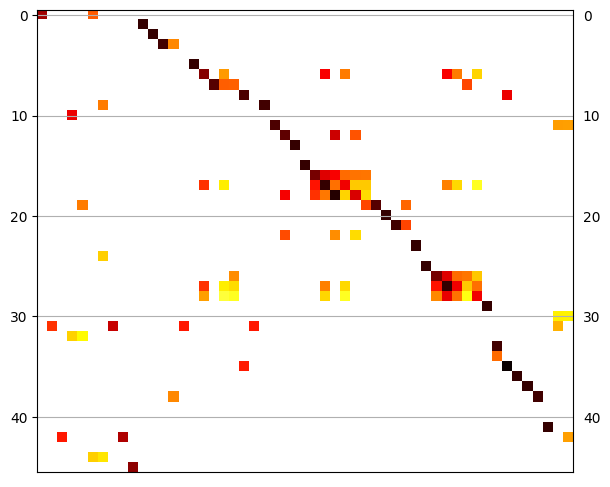

In [165]:
# First, since there are not too many combinations, 
# let's have a look at the whole similarity matrix (of the similarity of all possible pairs)
from equate import similarity_matrix
from oplot.matrix import heatmap

similarities = similarity_matrix(repo_collection_names, repo_endpoints)
print(f"{similarities.shape=}")
heatmap(similarities)

In [428]:
# It looks like we should be able to find a clear column-winner (an endpoint)
# for each row (collection_name). 
# But careful, the algorithm (said "greedy") that would just take the best match for 
# each row, might not get your the global best matching. 
# Let's be a bit more subtle than that, since we have matching algoriths at our disposal. 
from equate import match_keys_to_values, hungarian_matching

matches = dict(match_keys_to_values(repo_collection_names, repo_endpoints, matcher=hungarian_matching))
# matches

In [180]:
# So now we can get the information we want for each of our collection names
# simply by copying over the information from the endpoint that was matched to it.

route_for_collection_names = {k: routes['get', v] for k, v in matches.items()}

# Get the output names for each collection name

output_names = {
    name: list(route.output_properties) for name, route in route_for_collection_names.items()
}


In [209]:
from functools import cached_property
from typing import Callable


class PropertiesCollection:
    def __init__(self, properties_info: dict):
        self.properties_info = properties_info
    
    def __len__(self):
        return len(self.properties_info)
    
    @cached_property
    def output_properties(self):
        return {k: v.output_properties for k, v in self.properties_info.items()}
    
    @cached_property
    def names(self):
        return {k: list(v) for k, v in self.output_properties.items()}
    
    @cached_property
    def names_that_have_descriptions(self):
        return {
            k: [name for name, desc in v.output_properties.items() if desc] 
            for k, v in self.properties_info.items()
        }
    
    @cached_property
    def num_of_names(self):
        return {k: len(v) for k, v in self.output_properties.items()}
    
    def output_properties_filtered(self, filt: Callable):
        d = {
            k: {name: desc for name, desc in v.items() if filt(desc)} 
            for k, v in self.output_properties.items()
        }
        return {k: v for k, v in d.items() if v}

        

collection_props = PropertiesCollection(route_for_collection_names)
# collection_props.num_of_names['issues']
# collection_props.num_of_names
len(collection_props)


46

In [197]:
collection_props.names['artifacts']

['total_count', 'artifacts']

In [326]:
import pandas as pd

# d = pd.DataFrame.from_records(collection_props.names).T
def pad_lists(d):
    max_len = max(len(lst) for lst in d.values())
    return {k: (v + [None] * (max_len - len(v))) for k, v in d.items()}

padded_names = pad_lists(collection_props.names)
d = pd.DataFrame.from_records(padded_names).T

def names_with_one_value(names):
    return {k: 1 for k in names}

padded_names = {k: names_with_one_value(v) for k, v in collection_props.names.items()}
d = pd.DataFrame(padded_names).T 
# sort the columns by the most frequent (i.e. by d.sum())
d = d[d.sum().sort_values(ascending=False).index]
d.fillna('')

,id,url,node_id,html_url,created_at,updated_at,name,total_count,body,author_association,...,clone_url,mirror_url,hooks_url,svn_url,homepage,language,forks_count,stargazers_count,watchers_count,workflows
artifacts,,,,,,,,1.0,,,...,,,,,,,,,,
assignees,1.0,1.0,1.0,1.0,,,1.0,,,,...,,,,,,,,,,
autolinks,1.0,,,,,,,,,,...,,,,,,,,,,
branches,,,,,,,1.0,,,,...,,,,,,,,,,
codescan_alerts,,,,,,,,1.0,,,...,,,,,,,,,,
collaborators,1.0,1.0,1.0,1.0,,,1.0,,,,...,,,,,,,,,,
comments,1.0,1.0,1.0,1.0,1.0,1.0,,,1.0,1.0,...,,,,,,,,,,
commits,,1.0,1.0,1.0,,,,,,,...,,,,,,,,,,
contributors,1.0,1.0,1.0,1.0,,,1.0,,,,...,,,,,,,,,,
deployments,1.0,1.0,1.0,,1.0,1.0,,,,,...,,,,,,,,,,


In [427]:
def choose_keys(d):
    for collection_name, names in d.T.items():
        names = names.dropna().index.tolist()
        # print(names)
        # break
        if 'number' in names:
            yield collection_name, 'number'
        elif 'name' in names:
            yield collection_name, 'name'
        elif 'id' in names:
            yield collection_name, 'id'
        # elif 'comments' in names:
        #     yield collection_name, 'comments'
        else:
            yield collection_name, None
        
    
# dict(choose_keys(d))

In [328]:
collections_not_having_names_yet = [k for k, v in choose_keys(d) if not v]
collections_not_having_names_yet

['artifacts',
 'codescan_alerts',
 'commits',
 'downloads',
 'environments',
 'git_refs',
 'languages',
 'network_events',
 'pending_invitations',
 'repository_advisories',
 'secrets',
 'self_hosted_runners',
 'stargazers',
 'stats_contributors',
 'topics',
 'variables',
 'watchers',
 'workflow_runs',
 'workflows']

In [329]:
d.loc[collections_not_having_names_yet, :]

,id,url,node_id,html_url,created_at,updated_at,name,total_count,body,author_association,...,clone_url,mirror_url,hooks_url,svn_url,homepage,language,forks_count,stargazers_count,watchers_count,workflows
artifacts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
codescan_alerts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
commits,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
downloads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
environments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
git_refs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
languages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
network_events,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pending_invitations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repository_advisories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [330]:
import numpy as np
t = d.sum()
t['number']
d['number'].dropna()

issues           1.0
milestones       1.0
projects         1.0
pulls            1.0
top_referrers    1.0
Name: number, dtype: float64

In [331]:
import numpy as np
t = d.sum()
t['name']
d['name'].dropna()

assignees        1.0
branches         1.0
collaborators    1.0
contributors     1.0
forks            1.0
hooks            1.0
labels           1.0
projects         1.0
releases         1.0
subscribers      1.0
tags             1.0
teams            1.0
top_paths        1.0
Name: name, dtype: float64

In [228]:
# It seems like the fields "number" (for issues), "id", and "name" are good candidates 
# for the unique key for the repo-level collections (issues, actions, etc.)
# But though "number" means is a unique identifier for issues, it may not for other collections.

for name in d['number'].dropna().index.values:
    desc = collection_props.output_properties[name]['number'].get('description', '')
    print(
        f"{name} number description:\t{desc}"
    )

issues number description:	Number uniquely identifying the issue within its repository
milestones number description:	The number of the milestone.
projects number description:	
pulls number description:	
top_referrers number description:	


In [224]:
collection_props.output_properties['issues']['number']

{'description': 'Number uniquely identifying the issue within its repository',
 'example': 42,
 'type': 'integer'}

## Asking chatGPT to find a property name to use as a key.

Here, I'll just write some code to extract some condensed information about the collections and 
their parameters, so I can give it to chatGPT and ask it to figure out a param to use for a unique id
for each collection.

In [315]:
def extract_fields(d, fields):
    for field in fields:
        if field in d:
            yield field, d[field]

def extract_fields_from_values(d, fields, *, return_empty_extraction=False):
    for k, v in d.items():
        extraction = dict(extract_fields(v, fields))
        if extraction or return_empty_extraction:
            yield k, dict(extract_fields(v, fields))

def prop_string_info_string(prop_props):
    t = f'{prop_props.get("description", "")}'
    if example := prop_props.get('example', ""):
        # print(example)
        t += f" (e.g. {example})"
    return t

from functools import partial

def output_props_extraction():
    _extractor = partial(
        extract_fields_from_values, 
        fields=['description', 'example'], 
        return_empty_extraction=False
    )
    def gen():
        for collection in collection_props.output_properties:
            # print(collection)
            def _gen():
                props = collection_props.output_properties[collection]
                for name, name_props in _extractor(props):
                    if name_props:
                        # print(props)
                        # print(props)
                        yield f"{name}: {prop_string_info_string(name_props)}"
            t = '\n\t'.join(_gen())
            if t:
                yield collection, '\n\t' + t
    # return gen()
    return '\n\n'.join(f"{k}: {v}" for k, v in gen())

# dict(extract_fields_from_values(collection_props.output_properties['issues'], ['description', 'example']))
collections_and_params_info = output_props_extraction()
import pyperclip
pyperclip.copy(collections_and_params_info)


In [332]:
prompt = """The text above has the format:

COLLECTION_NAME:
    PARAM_NAME: PARAM_INFO
    PARAM_NAME: PARAM_INFO
    ...

For each collection, I need to find a param_name that can be used as a unique id for a set of items of the collection. Please give me a csv of the following format:

collection_name, your_best_choice_param_name_for_a_unique_id
"""

# Note: I needed two more requests after that prompt.
# One where I told chatGPT that it missed some collections, told it which, and asked for a new table.
# A second where I disagreed with some matches, told it which, asked it to figure out "step by step" why that was, 
# and then make a new table.
# The result is below

response = """collection_name, your_best_choice_param_name_for_a_unique_id
assignees, id
autolinks, id
branches, name
collaborators, id
comments, user
commits, sha
deployments, id
downloads, temp_download_token
environments, url
events, actor
forks, id
hooks, id
issues, number
issues_comments, id
issues_events, id
labels, id
milestones, id
network_events, id
notifications, repository
pending_invitations, url
projects, id
pulls, id
pulls_comments, id
pulls_review_comments, id
releases, tag_name
repository_advisories, id
secrets, name
self_hosted_runners, id
stargazers, user
stargazers_with_dates, user
stats_contributors, author
subscribers, id
tags, name
teams, html_url
top_paths, html_url
top_referrers, url
topics, name
variables, id
artifacts, id
codescan_alerts, id
watchers, user
workflow_runs, id
workflows, id
contributors, login
languages, name
git_refs, ref
"""

import pandas as pd 
import io
response_df = pd.read_csv(io.StringIO(response))
response_df

,collection_name,your_best_choice_param_name_for_a_unique_id
0,assignees,id
1,autolinks,id
2,branches,name
3,collaborators,id
4,comments,user
5,commits,sha
6,deployments,id
7,downloads,temp_download_token
8,environments,url
9,events,actor


In [333]:
print(f"{set(response_df['collection_name']) - set(repo_collection_names)=}")
print(f"{set(repo_collection_names) - set(response_df['collection_name'])=}")

set(response_df['collection_name']) - set(repo_collection_names)=set()
set(repo_collection_names) - set(response_df['collection_name'])=set()


In [375]:
import pandas as pd
import json
# repo_collections_key_props.json
def csv_to_json_string(response):
    import io
    # Read the CSV data from the response
    response_df = pd.read_csv(io.StringIO(response))

    response_df = pd.read_csv(io.StringIO(response))
    # apply str.strip to all cells of df
    response_df = response_df.applymap(str.strip)
    # apply str.strip to all column names
    response_df = response_df.rename(columns=str.strip)

    collection_and_id = zip(
        response_df['collection_name'], response_df['your_best_choice_param_name_for_a_unique_id']
    )
    jdict = {collection: id_name for collection, id_name in collection_and_id}
    return json.dumps(jdict, indent=4)

json_str = csv_to_json_string(response)

# print(json_str)
__import__('pyperclip').copy(json_str)



/var/folders/s0/6rhqzsnx0lxbjs8r5rhld9km0000gn/T/ipykernel_64120/1532311661.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  response_df = response_df.applymap(str.strip)


In [393]:
from hubcap.util import configs
list(configs)
configs.rootdir

'/Users/thorwhalen/.config/hubcap/configs/'

In [394]:
from hubcap import RepoReader


In [419]:
from hubcap import RepoReader

# r = RepoReader('thorwhalen/test_repo')
sorted(r)



['artifacts',
 'assignees',
 'autolinks',
 'branches',
 'codescan_alerts',
 'collaborators',
 'comments',
 'commits',
 'contributors',
 'deployments',
 'discussions',
 'downloads',
 'environments',
 'events',
 'forks',
 'git_refs',
 'hooks',
 'issues',
 'issues_comments',
 'issues_events',
 'labels',
 'languages',
 'milestones',
 'network_events',
 'notifications',
 'pending_invitations',
 'projects',
 'pulls',
 'pulls_comments',
 'pulls_review_comments',
 'releases',
 'repository_advisories',
 'secrets',
 'self_hosted_runners',
 'stargazers',
 'stargazers_with_dates',
 'stats_contributors',
 'subscribers',
 'tags',
 'teams',
 'top_paths',
 'top_referrers',
 'topics',
 'variables',
 'watchers',
 'workflow_runs',
 'workflows']

In [422]:
b = r['branches']
# dir(b)

['ItemsView',
 'KeysView',
 'ValuesView',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_objs',
 'data_of_obj',
 'get',
 'get_objs',
 'get_objs_kwargs',
 'head',
 'items',
 'keys',
 'objs_to_items',
 'repo',
 'values']

In [426]:
# # t = b.get_objs()
# list(b)

In [378]:
from hubcap.util import data_files

data_files.joinpath('dflt_repo_collections_key_props.json').read_text()

'{\n    "assignees": "id",\n    "autolinks": "id",\n    "branches": "name",\n    "collaborators": "id",\n    "comments": "user",\n    "commits": "sha",\n    "deployments": "id",\n    "downloads": "temp_download_token",\n    "environments": "url",\n    "events": "actor",\n    "forks": "id",\n    "hooks": "id",\n    "issues": "number",\n    "issues_comments": "id",\n    "issues_events": "id",\n    "labels": "id",\n    "milestones": "id",\n    "network_events": "id",\n    "notifications": "repository",\n    "pending_invitations": "url",\n    "projects": "id",\n    "pulls": "id",\n    "pulls_comments": "id",\n    "pulls_review_comments": "id",\n    "releases": "tag_name",\n    "repository_advisories": "id",\n    "secrets": "name",\n    "self_hosted_runners": "id",\n    "stargazers": "user",\n    "stargazers_with_dates": "user",\n    "stats_contributors": "author",\n    "subscribers": "id",\n    "tags": "name",\n    "teams": "html_url",\n    "top_paths": "html_url",\n    "top_referrers": "u

In [371]:
from hubcap.util import get_config

get_config('adsf')

''

In [363]:
dir(get_config)
get_config.configs

TextFiles(rootdir='/Users/thorwhalen/.config/hubcap/configs', subpath='', pattern_for_field=None, max_levels=None, include_hidden=False, assert_rootdir_existence=False)

In [24]:
from pydantic import BaseModel, create_model
from i2 import Sig, sort_params
from inspect import Parameter, Signature
from typing import List, Type, Dict, Any, Optional

# Default mapping from JSON types to Pydantic fields
default_type_mapping = {
    'array': (List[Any], ...),
    'integer': (int, ...),
    'object': (Dict[Any, Any], ...),
    'string': (str, ...),
    'boolean': (bool, ...),
    'number': (float, ...),
}

def json_to_pydantic_model(params: List[Dict[str, Any]], type_mapping: Dict[str, Type] = default_type_mapping) -> Type[BaseModel]:
    fields = {}
    for param in params:
        field_info = type_mapping[param['schema']['type']]
        # Set the default value if it's not required and a default is provided
        if not param.get('required', False) and 'default' in param['schema']:
            field_info = (field_info[0], param['schema']['default'])
        fields[param['name']] = field_info
    return create_model('DynamicModel', **fields)

def pydantic_model_to_sig(model: Type[BaseModel], return_annotation: Any = None) -> Signature:
    parameters = [
        Parameter(
            name=field.alias,
            kind=Parameter.POSITIONAL_OR_KEYWORD,
            default=field.default if not field.required else Parameter.empty,
            annotation=field.outer_type_ if field.outer_type_ != Any else field.type_,
        )
        for field in model.__fields__.values()
    ]
    sorted_parameters = sort_params(parameters)  # Assuming this sorts parameters suitably for your use-case
    return Signature(parameters=sorted_parameters, return_annotation=return_annotation)

# Example usage
params = [
    {
        'name': 'type',
        'schema': {'type': 'string'},
        'required': True,
        'description': 'Type of items to list',
    },
    {
        'name': 'limit',
        'schema': {'type': 'integer', 'default': 10},
        'required': False,
        'description': 'Maximum number of items to return',
    },
]

# Create a Pydantic model from the JSON schema parameters
DynamicModel = json_to_pydantic_model(params)

# Convert the Pydantic model to an inspect.Signature
sig = pydantic_model_to_sig(DynamicModel)

sig


<Signature (type: str, limit: int = 10) -> None>

In [8]:
from http2py.tests.util_test import _openapi_spec
from http2py.util import Routes

openapi_spec = _openapi_spec()

routes = Routes(openapi_spec)
get_route = routes['get', '/items']

assert get_route.parameters == [{'in': 'query',
  'name': 'type',
  'schema': {'type': 'string'},
  'required': True,
  'description': 'Type of items to list'},
 {'in': 'query',
  'name': 'limit',
  'schema': {'type': 'integer', 'default': 10},
  'required': False,
  'description': 'Maximum number of items to return'}]

post_route = routes['post', '/items']
assert post_route.parameters == [
    {'in': 'body', 'name': 'name', 'schema': {'type': 'string'}},
   {'in': 'body', 'name': 'age', 'schema': {'type': 'integer', 'default': 42}}]

In [30]:
from hubcap import RepoReader
from hubcap.constants import repo_collection_names

r = RepoReader('thorwhalen/hubcap').repo
for x in repo_collection_names:
    t = getattr(r, f"get_{x}")()
    if t:
        try:
            t = next(iter(t), None)
            if isinstance(t, dict):
                print(f"{x}: {list(t.keys())}")
            else:
                print(f"{x}: {[x for x in dir(t) if not x.startswith('_')]}")
        except Exception as e:
            print(f"{x}: ERROR: {e}")

artifacts: []
assignees: ['CHECK_AFTER_INIT_FLAG', 'avatar_url', 'bio', 'blog', 'collaborators', 'company', 'contributions', 'created_at', 'disk_usage', 'email', 'etag', 'events_url', 'followers', 'followers_url', 'following', 'following_url', 'get__repr__', 'get_events', 'get_followers', 'get_following', 'get_gists', 'get_keys', 'get_organization_membership', 'get_orgs', 'get_projects', 'get_public_events', 'get_public_received_events', 'get_received_events', 'get_repo', 'get_repos', 'get_starred', 'get_subscriptions', 'get_watched', 'gists_url', 'gravatar_id', 'has_in_following', 'hireable', 'html_url', 'id', 'invitation_teams_url', 'inviter', 'last_modified', 'location', 'login', 'name', 'node_id', 'organizations_url', 'owned_private_repos', 'permissions', 'plan', 'private_gists', 'public_gists', 'public_repos', 'raw_data', 'raw_headers', 'received_events_url', 'repos_url', 'role', 'setCheckAfterInitFlag', 'site_admin', 'starred_url', 'subscriptions_url', 'suspended_at', 'team_count

Request GET /repos/thorwhalen/hubcap/code-scanning/alerts failed with 403: Forbidden


codescan_alerts: ERROR: 403 {"message": "You are not authorized to read code scanning alerts.", "documentation_url": "https://docs.github.com/rest/code-scanning/code-scanning#list-code-scanning-alerts-for-a-repository"}
collaborators: ERROR: 401 {"message": "Requires authentication", "documentation_url": "https://docs.github.com/rest/collaborators/collaborators#list-repository-collaborators"}
comments: []
commits: ['CHECK_AFTER_INIT_FLAG', 'author', 'comments_url', 'commit', 'committer', 'create_comment', 'create_status', 'etag', 'files', 'get__repr__', 'get_check_runs', 'get_check_suites', 'get_combined_status', 'get_comments', 'get_pulls', 'get_statuses', 'html_url', 'last_modified', 'parents', 'raw_data', 'raw_headers', 'setCheckAfterInitFlag', 'sha', 'stats', 'update', 'url']
contributors: ['CHECK_AFTER_INIT_FLAG', 'avatar_url', 'bio', 'blog', 'collaborators', 'company', 'contributions', 'created_at', 'disk_usage', 'email', 'etag', 'events_url', 'followers', 'followers_url', 'follo

Request GET /networks/thorwhalen/hubcap/events failed with 403: rate limit exceeded
Setting next backoff to 2746.164692s


In [6]:
r = RepoReader('thorwhalen/hubcap')
print(*r)


artifacts assignees autolinks branches codescan_alerts collaborators comments commits contributors deployments downloads events forks git_refs hooks issues issues_comments issues_events labels languages milestones network_events notifications pending_invitations projects pulls pulls_comments pulls_review_comments releases self_hosted_runners stargazers stargazers_with_dates stats_contributors subscribers tags teams top_paths top_referrers topics watchers workflow_runs workflows


In [115]:
from hubcap.tools import Hubcap

s = Hubcap('thorwhalen/hubcap')
list(s)



['master']

In [109]:
dflt_repo_kwargs = dict(
    issues=dict(objs_to_items='number', get_objs_kwargs=(('state', 'open'),)),
    workflows=dict(objs_to_items='id'),
)

def repo_objects_instance(repo, object_name: str):
    return RepoObjects(
        repo, 
        get_objs=getattr(Repository, f'get_{object_name}'), 
        **dflt_repo_kwargs.get(object_name, {})
    )

issues = repo_objects_instance(r, 'issues')
list(issues)

[3]

In [110]:
issues[3]

Issue(title="Test Issue", number=3)

In [89]:
r.get_git_matching_refs()

TypeError: Repository.get_git_matching_refs() missing 1 required positional argument: 'ref'

In [88]:
from i2 import Sig

get_funcs = {
    k: Sig(getattr(r, k)) for k in dir(r) if k.startswith('get_') and k.endswith('s')
}
get_funcs

{'get_artifacts': <Sig ()>,
 'get_assignees': <Sig ()>,
 'get_autolinks': <Sig ()>,
 'get_branches': <Sig ()>,
 'get_codescan_alerts': <Sig ()>,
 'get_collaborators': <Sig (affiliation=NotSet)>,
 'get_comments': <Sig ()>,
 'get_commits': <Sig (sha=NotSet, path=NotSet, since=NotSet, until=NotSet, author=NotSet)>,
 'get_contents': <Sig (path, ref=NotSet)>,
 'get_contributors': <Sig (anon=NotSet)>,
 'get_deployments': <Sig (sha=NotSet, ref=NotSet, task=NotSet, environment=NotSet)>,
 'get_dir_contents': <Sig (path, ref=NotSet)>,
 'get_downloads': <Sig ()>,
 'get_events': <Sig ()>,
 'get_forks': <Sig ()>,
 'get_git_matching_refs': <Sig (ref)>,
 'get_git_refs': <Sig ()>,
 'get_hooks': <Sig ()>,
 'get_issues': <Sig (milestone=NotSet, state=NotSet, assignee=NotSet, mentioned=NotSet, labels=NotSet, sort=NotSet, direction=NotSet, since=NotSet, creator=NotSet)>,
 'get_issues_comments': <Sig (sort=NotSet, direction=NotSet, since=NotSet)>,
 'get_issues_events': <Sig ()>,
 'get_keys': <Sig ()>,
 'ge

In [42]:
r.get_issues

<bound method Repository.get_issues of Repository(full_name="thorwhalen/hubcap")>

In [52]:
from github.Repository import Repository
from functools import partial

mk_issues = partial(
    GitObjects, 
    get_objs=Repository.get_issues, 
    objs_to_items='number'
)

s = mk_issues(r)
list(s)

[3]

In [54]:
mk_workflows = partial(
    GitObjects, 
    get_objs=Repository.get_workflows, 
    objs_to_items='id'
)

s = mk_workflows(r)
list(s)

[15622701, 19162183]

In [ ]:

    def __init__(
        self,
        repo: RepoSpec,
        *,
        issue_key: str = 'number',
        state="open",
        **issues_filt,
    ):
        """
        :param repo: :class:`github.Repository.Repository`
        :param issue_key: str, or callable that takes an iterable of issues and returns
            an iterable of (key, issue) pairs (e.g. `enumerate`).
            If str, then the attribute of the issue to use as the key.
        """
        self.src = ensure_repo_obj(repo)
        if isinstance(issue_key, str):
            key_attr = issue_key
            _get_key = attrgetter(key_attr)
            self._issue_key = lambda x: zip(map(_get_key, x), x)
        else:
            assert callable(issue_key), "issue_key must be a str or callable"
            self._issue_key = issue_key
        self.state = state
        self.issues_filt = issues_filt

    @cached_property
    def _issues(self):
        return {
            k: v
            for k, v in self._issue_key(
                self.src.get_issues(state=self.state, **self.issues_filt)
            )
        }

    def __iter__(self):
        yield from self._issues

    def __getitem__(self, k):
        return self._issues[k]


# Objects

In [6]:
from hubcap import GithubReader

gr = GithubReader()
gr._github.get_user(), gr.src

(AuthenticatedUser(login=None), AuthenticatedUser(login=None))

In [7]:
gr = GithubReader('i2mint')
gr.src

NamedUser(login="i2mint")

In [30]:
from hubcap import hub

repositories = hub('thorwhalen')
'hubcap' in repositories
hubcap_repo = repositories['hubcap']

repo = hub('thorwhalen/hubcap')
'master' in repo
master_files = repo['master']

files = hub('thorwhalen/hubcap/master')
'/README.md' in files
'/hubcap/' in files
hubcap_files = files['/hubcap/']
'/hubcap/base.py' in hubcap_files


discussions = hub('thorwhalen/hubcap/discussions')
2 in discussions
discussion = discussions[2]
discussion['title']


False

In [13]:
from hubcap import hub
issues = hub('thorwhalen/hubcap/issues')
3 in issues  # there's a "number 3" issue
issue = issues[3]
issue.title
issue.body
issue.comments



1

In [14]:
# TODO: This doesn't work yet
hubcap_files_ = hub('thorwhalen/hubcap/master/hubcap/')
'/hubcap/base.py' in hubcap_files_
# s = hub('thorwhalen/hubcap/tree/b21958421d2eddfa9340f710e933a454938d4dcb')



False

In [19]:
b = hub('thorwhalen/hubcap')
r = b.src

In [20]:
a = r.get_workflows()

In [31]:
for aa in a:
    pass
    # print(aa)

In [32]:
aa

Workflow(url="https://api.github.com/repos/thorwhalen/hubcap/actions/workflows/19162183", name="pages-build-deployment")

In [24]:
from hubcap.base import PaginatedListDol

t = PaginatedListDol(a)

In [26]:
it = iter(t)

In [27]:
next(it)

Workflow(url="https://api.github.com/repos/thorwhalen/hubcap/actions/workflows/15622701", name="Continuous Integration")

# Exploring github APIs possibilities

In [1]:
import os
from github import Github

ddir = lambda o: [a for a in dir(o) if not a.startswith('_')]
print(*ddir(Github), sep=', ')

FIX_REPO_GET_GIT_REF, create_from_raw_data, dump, get_app, get_emojis, get_events, get_gist, get_gists, get_gitignore_template, get_gitignore_templates, get_hook, get_hooks, get_license, get_licenses, get_oauth_application, get_organization, get_organizations, get_project, get_project_column, get_rate_limit, get_repo, get_repos, get_user, get_user_by_id, get_users, load, oauth_scopes, per_page, rate_limiting, rate_limiting_resettime, render_markdown, search_code, search_commits, search_issues, search_repositories, search_topics, search_users


In [2]:
get_methods = [a for a in dir(Github) if a.startswith('get_')]
get_names = [a[4:] for a in get_methods]
get_names

['app',
 'emojis',
 'events',
 'gist',
 'gists',
 'gitignore_template',
 'gitignore_templates',
 'hook',
 'hooks',
 'license',
 'licenses',
 'oauth_application',
 'organization',
 'organizations',
 'project',
 'project_column',
 'rate_limit',
 'repo',
 'repos',
 'user',
 'user_by_id',
 'users']

In [72]:
print_attrs_info(Github)

----- Methods -----
         get_rate_limit: 
            get_license: key
           get_licenses: 
             get_events: 
               get_user: login
         get_user_by_id: user_id
              get_users: since
       get_organization: login
      get_organizations: since
               get_repo: full_name_or_id, lazy
              get_repos: since, visibility
            get_project: id
     get_project_column: id
               get_gist: id
              get_gists: since
    search_repositories: query, sort, order, qualifiers
           search_users: query, sort, order, qualifiers
          search_issues: query, sort, order, qualifiers
            search_code: query, sort, order, highlight, qualifiers
         search_commits: query, sort, order, qualifiers
          search_topics: query, qualifiers
        render_markdown: text, context
               get_hook: name
              get_hooks: 
get_gitignore_templates: 
 get_gitignore_template: name
             get_emojis: 


In [3]:
g = Github()

In [4]:
t = g.get_user('thorwhalen')
t

NamedUser(login="thorwhalen")

In [5]:
type(t).mro()

[github.NamedUser.NamedUser,
 github.GithubObject.CompletableGithubObject,
 github.GithubObject.GithubObject,
 object]

In [8]:
from hubcap.base import PaginatedListDol
p = PaginatedListDol(t.get_followers())
list(p)

[NamedUser(login="thejeshgn"),
 NamedUser(login="Rokotyan"),
 NamedUser(login="yz-"),
 NamedUser(login="Magicianred"),
 NamedUser(login="iDoka"),
 NamedUser(login="leb9212"),
 NamedUser(login="cavart28"),
 NamedUser(login="izcet"),
 NamedUser(login="andeaseme"),
 NamedUser(login="jakka351"),
 NamedUser(login="zfeng10")]

In [120]:
print_attrs_info(t)

----- Methods -----
                get__repr__: params
                 get_events: 
              get_followers: 
              get_following: 
                  get_gists: since
                   get_keys: 
get_organization_membership: org
                   get_orgs: 
               get_projects: state
          get_public_events: 
 get_public_received_events: 
        get_received_events: 
                   get_repo: name
                  get_repos: type, sort, direction
                get_starred: 
          get_subscriptions: 
                get_watched: 
           has_in_following: following
      setCheckAfterInitFlag: flag
                     update: additional_headers
------ Props ------
CHECK_AFTER_INIT_FLAG
avatar_url
bio
blog
collaborators
company
contributions
created_at
disk_usage
email
etag
events_url
followers
followers_url
following
following_url
gists_url
gravatar_id
hireable
html_url
id
invitation_teams_url
inviter
last_modified
location
login
name
node_id
o

In [122]:
r = t.get_repos()
print_attrs_info(r)

----- Methods -----
  get_page: page
------ Props ------
reversed
totalCount


In [429]:
from hubcap.base import PaginatedListDol

rr = PaginatedListDol(r)
repositories = list(rr)
# repositories

In [171]:
s = g.search_repositories('sound recognition')
s.totalCount

566

In [170]:
list(s)

[Repository(full_name="carlosmwh1985/sound_recognition_ml"),
 Repository(full_name="otosense/viable"),
 Repository(full_name="ChaimTeitelbaum/Project_3_ML_sound_recognition"),
 Repository(full_name="MahmoodAbuAwwad/Sound_Detection_ML"),
 Repository(full_name="saurabh23897/FaultyTileSoundRecognition_PythonML"),
 Repository(full_name="tayciryahmed/ml-challenges"),
 Repository(full_name="chelakis/---Automatic-Speaker-Recognition-using-ML"),
 Repository(full_name="jogomez97/BirdMLClassification"),
 Repository(full_name="snpushpi/Speech_Emotion_recognition_Project"),
 Repository(full_name="doans/Underwater-Acoustic-Target-Classification-Based-on-Dense-Convolutional-Neural-Network"),
 Repository(full_name="erikd234/BikeSentry"),
 Repository(full_name="AnbuKumar-maker/Machine-Learning---Sensor-Data-Analytics")]

In [158]:
repo = repositories[19]
repo

Repository(full_name="thorwhalen/graze")

In [430]:
# print_attrs_info(repo)

In [160]:
w = PaginatedListDol(repo.get_commits())
len(w)

24

In [431]:
# w = PaginatedListDol(g.get_repo('i2mint/dol').get_commits())
# print(f"{len(w)=}")
# ww = list(w.paginated_list)
# print(f"{len(ww)=}")
# ww

In [157]:
repo = g.get_repo('i2mint/dol')
repo

Repository(full_name="i2mint/dol")

In [432]:
# w = PaginatedListDol(repo.get_collaborators())
# list(w)

In [125]:
type(r).mro()

[github.PaginatedList.PaginatedList,
 github.PaginatedList.PaginatedListBase,
 object]

In [121]:
p = t.get_gists()
print_attrs_info(p)

----- Methods -----
  get_page: page
------ Props ------
reversed
totalCount


In [112]:
p.totalCount

18

In [433]:
# for x in type(t).mro():
#     print(f'******** {x} *************')
#     print_attrs_info(x)

In [73]:
print_attrs_info(t)

ValueError: max() arg is an empty sequence

In [434]:
# tt = g.get_repo()

In [436]:
from hubcap import RepoReader

repo = RepoReader('thorwhalen/hubcap')

In [437]:
list(repo)

['artifacts',
 'assignees',
 'autolinks',
 'branches',
 'codescan_alerts',
 'collaborators',
 'comments',
 'commits',
 'contributors',
 'deployments',
 'discussions',
 'downloads',
 'environments',
 'events',
 'forks',
 'git_refs',
 'hooks',
 'issues',
 'issues_comments',
 'issues_events',
 'labels',
 'languages',
 'milestones',
 'network_events',
 'notifications',
 'pending_invitations',
 'projects',
 'pulls',
 'pulls_comments',
 'pulls_review_comments',
 'releases',
 'repository_advisories',
 'secrets',
 'self_hosted_runners',
 'stargazers',
 'stargazers_with_dates',
 'stats_contributors',
 'subscribers',
 'tags',
 'teams',
 'top_paths',
 'top_referrers',
 'topics',
 'variables',
 'watchers',
 'workflow_runs',
 'workflows']

In [1]:
from hubcap import hub
repositories = hub('thorwhalen')
hubcap_repo = repositories['hubcap']

In [440]:
hubcap_repo

Branches(Repository(full_name="thorwhalen/hubcap"), <function decoded_contents at 0x11710bbe0>)

In [441]:
'master' in hubcap_repo

True

In [8]:
repo = hub('thorwhalen/hubcap/')
repo

RepoReader("thorwhalen/hubcap")

In [5]:
self = repo
self.repo.full_name

'thorwhalen/hubcap'

In [9]:
from hubcap import RepoReader
r = RepoReader('thorwhalen/hubcap')
r

RepoReader("thorwhalen/hubcap")

In [12]:
branches = r['branches']

In [14]:
repo = hub('thorwhalen/hubcap')
repo

RepoReader("thorwhalen/hubcap")

In [15]:
branch = branches['master']
branch

Branch(name="master")

In [22]:
type(branch)

github.Branch.Branch

In [25]:
from github import Github

g = Github()
# assuming you have a Github instance g
repo = g.get_repo("thorwhalen/hubcap")  # replace "your_repo" with your repository
branch = repo.get_branch("master")  # or replace "master" with your branch

# Get the commit for this branch
commit = branch.commit

In [21]:

branch.raw_data

{'name': 'master',
 'commit': {'sha': 'ec39462eebe8ecf6a00097f7022fe0198457a110',
  'url': 'https://api.github.com/repos/thorwhalen/hubcap/commits/ec39462eebe8ecf6a00097f7022fe0198457a110'},
 'protected': False}

In [19]:
# get the files in the master branch
files = branch['/']
files

TypeError: 'Branch' object is not subscriptable

In [20]:
from hubcap import Github

Github

# repo = git.Repo('path_to_your_repo')
# files = repo.tree().blobs

github.MainClass.Github

In [36]:
from hubcap import GithubReader
r = GithubReader('thorwhalen')  # connnecting to a particular user/organization



In [34]:
import hubcap
hubcap.GithubReader

hubcap.base.GithubReader

In [37]:
branches = GithubReader('thorwhalen')['hubcap']
branches

Branches(Repository(full_name="thorwhalen/hubcap"), <function decoded_contents at 0x111fed360>)

In [39]:
list(branches)

['master']

In [40]:
b = branches['master']
b

BranchDir(Repository(full_name="thorwhalen/hubcap"), 'master', '', <function decoded_contents at 0x111fed360>)

In [42]:
list(b)

['/.gitattributes',
 '/.github/',
 '/.gitignore',
 '/LICENSE',
 '/README.md',
 '/docsrc/',
 '/hubcap/',
 '/misc/',
 '/setup.cfg',
 '/setup.py']

# Transfering discussions (with private repos)

In [ ]:
from hubcap import copy_discussion

source_discussion_url = "https://github.com/addaix/priv_addix/discussions/5"  # Replace with your source discussion URL
target_repo_url = "https://github.com/thorwhalen/ideas"         # Replace with your target repository URL

copy_discussion(source_discussion_url, target_repo_url)


--- Starting Discussion Copy ---
Source Discussion: https://github.com/addaix/priv_addix/discussions/5
Target Repository: https://github.com/thorwhalen/ideas
Getting target repository ID and discussion categories for 'thorwhalen/ideas'...
Available discussion categories in target repository:
  - Name: Announcements, ID: DIC_kwDOJgm4884CWXPC
  - Name: General, ID: DIC_kwDOJgm4884CWXPD
  - Name: Ideas, ID: DIC_kwDOJgm4884CWXPF
  - Name: Polls, ID: DIC_kwDOJgm4884CWXPH
  - Name: Q&A, ID: DIC_kwDOJgm4884CWXPE
  - Name: Show and tell, ID: DIC_kwDOJgm4884CWXPG
Fetching discussion #5 from 'addaix/priv_addix'...
Creating new discussion in 'thorwhalen/ideas' under category 'General'...
New discussion created: https://github.com/thorwhalen/ideas/discussions/6
New discussion ID: D_kwDOJgm4884AgIxO
Copying comments...
  - Copied comment 1/3
  - Copied comment 2/3
  - Copied comment 3/3
--- Discussion Copy Complete ---
New discussion available at: https://github.com/thorwhalen/ideas/discussions/6


# Parsing github urls

In [ ]:
import os
from functools import partial
from operator import methodcaller, attrgetter
from dol import Pipe

readme_of_package = Pipe(
    attrgetter('__file__'),
    os.path.dirname,
    os.path.dirname,
    partial(partial, os.path.join),  # partial of partial! Reflect on the uses cases for this!
    methodcaller('__call__', 'README.md'),
)

import oplot

path_to_readme = readme_of_package(oplot)
path_to_readme

'/Users/thorwhalen/Dropbox/py/proj/i/o/oplot/README.md'

In [10]:
from hubcap import parse_github_url, transform_github_url, generate_github_url
from hubcap.util import _github_url_templates_names

url = 'https://github.com/i2mint/oplot/blob/master/readme_plots/Screen Shot 2021-01-06 at 07.21.26.png'

raw_url = transform_github_url(url, target_url_type='raw_file')
raw_url


'https://raw.githubusercontent.com/i2mint/oplot/master/readme_plots/Screen Shot 2021-01-06 at 07.21.26.png'

In [13]:
from pathlib import Path

readme_text = Path(path_to_readme).read_text()

# find and replace all urls of readme_text of the form 'https://github.com/i2mint/oplot/blob/master/readme_plots/
# with their raw file counterpart
# use regex to detect the urls, then apply partial(transform_github_url, target_url_type='raw_file') to each of them

from hubcap import transform_github_url
from functools import partial

from re import sub

def replace_github_urls_with_raw_file_urls(text: str) -> str:
    return sub(
        r'https://github\.com/([^/]+)/([^/]+)/blob/([^/]+)/([^ ]+)',
        lambda match: partial(transform_github_url, target_url_type='raw_file')(match.group(0)),
        text
    )

new_readme_text = replace_github_urls_with_raw_file_urls(readme_text)
Path(path_to_readme).write_text(new_readme_text)


13241